<a href="https://colab.research.google.com/github/abhinavsagar/Self-Driving-Car/blob/master/autonomous_car.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
print(sys.path)

['/Users/dp.krylov/Desktop/self-driving', '/Users/dp.krylov/opt/anaconda3/lib/python37.zip', '/Users/dp.krylov/opt/anaconda3/lib/python3.7', '/Users/dp.krylov/opt/anaconda3/lib/python3.7/lib-dynload', '', '/Users/dp.krylov/opt/anaconda3/lib/python3.7/site-packages', '/Users/dp.krylov/opt/anaconda3/lib/python3.7/site-packages/aeosa', '/Users/dp.krylov/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions', '/Users/dp.krylov/.ipython']


In [2]:
paths = ['/Library/Frameworks/Python.framework/Versions/3.9/lib/python39.zip', '/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9', '/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/lib-dynload', '/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages']

for e in paths:
    sys.path.append(e)

In [3]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as npimg
import os
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras import initializers
import cv2
import pandas as pd
import random
import ntpath
import tensorflow as tf

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle

In [4]:
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join('dataset_self_driving', 'driving_log.csv'), names = columns)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,/Users/dmitry/Desktop/dataset_self_driving/IMG...,/Users/dmitry/Desktop/dataset_self_driving/IMG...,/Users/dmitry/Desktop/dataset_self_driving/IMG...,0.0,0.0,0.0,2.142940
1,/Users/dmitry/Desktop/dataset_self_driving/IMG...,/Users/dmitry/Desktop/dataset_self_driving/IMG...,/Users/dmitry/Desktop/dataset_self_driving/IMG...,0.0,0.0,0.0,2.161471
2,/Users/dmitry/Desktop/dataset_self_driving/IMG...,/Users/dmitry/Desktop/dataset_self_driving/IMG...,/Users/dmitry/Desktop/dataset_self_driving/IMG...,0.0,0.0,0.0,2.179401
3,/Users/dmitry/Desktop/dataset_self_driving/IMG...,/Users/dmitry/Desktop/dataset_self_driving/IMG...,/Users/dmitry/Desktop/dataset_self_driving/IMG...,0.0,0.0,0.0,2.192274
4,/Users/dmitry/Desktop/dataset_self_driving/IMG...,/Users/dmitry/Desktop/dataset_self_driving/IMG...,/Users/dmitry/Desktop/dataset_self_driving/IMG...,0.0,0.0,0.0,2.208590


In [5]:
def cut_path(path):
    head, tail = ntpath.split(path)
    return tail

data['center'] = data['center'].apply(cut_path)
data['left'] = data['left'].apply(cut_path)
data['right'] = data['right'].apply(cut_path)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2021_06_17_18_28_00_474.jpg,left_2021_06_17_18_28_00_474.jpg,right_2021_06_17_18_28_00_474.jpg,0.0,0.0,0.0,2.142940
1,center_2021_06_17_18_28_00_547.jpg,left_2021_06_17_18_28_00_547.jpg,right_2021_06_17_18_28_00_547.jpg,0.0,0.0,0.0,2.161471
2,center_2021_06_17_18_28_00_619.jpg,left_2021_06_17_18_28_00_619.jpg,right_2021_06_17_18_28_00_619.jpg,0.0,0.0,0.0,2.179401
3,center_2021_06_17_18_28_00_687.jpg,left_2021_06_17_18_28_00_687.jpg,right_2021_06_17_18_28_00_687.jpg,0.0,0.0,0.0,2.192274
4,center_2021_06_17_18_28_00_759.jpg,left_2021_06_17_18_28_00_759.jpg,right_2021_06_17_18_28_00_759.jpg,0.0,0.0,0.0,2.208590


A lot of labels is 'keep forward'

<BarContainer object of 25 artists>

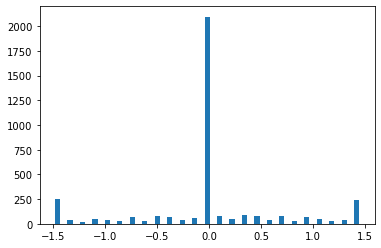

In [6]:
num_bins = 25
hist, bins = np.histogram(data['steering'], num_bins)
center = bins[:-1] + bins[1:] * 0.5  # center the bins to 0
plt.bar(center, hist, width=0.05)

<BarContainer object of 25 artists>

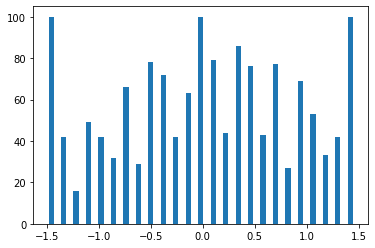

In [7]:
#remove extra points for balancing

remove_list = []
for j in range(num_bins):
    list_ = []
    for i in range(len(data['steering'])):
        steering_angle = data['steering'][i]
        if steering_angle >= bins[j] and steering_angle <= bins[j+1]:
            list_.append(i)
    list_ = shuffle(list_)
    list_ = list_[100:]
    remove_list.extend(list_)

data.drop(data.index[remove_list], inplace=True)

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)

In [8]:
def load_img_steering(datadir, df):
    image_path = []
    steering = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        image_path.append(os.path.join(datadir, center.strip()))
        steering.append(float(indexed_data[3]))
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    return image_paths, steerings

image_paths, steerings = load_img_steering('dataset_self_driving/IMG', data)

1168 292


Text(0.5, 1.0, 'Val')

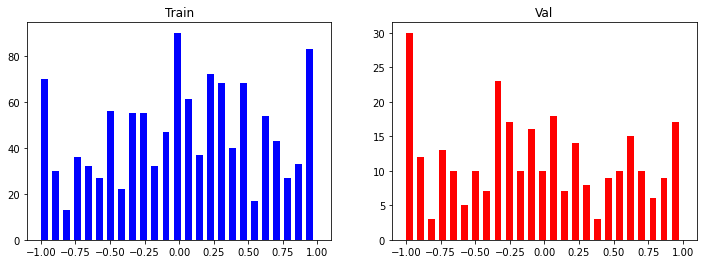

In [9]:
X_train, X_valid, Y_train, Y_valid = train_test_split(image_paths, steerings, test_size=0.2)

print(len(X_train), len(X_valid))
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(Y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Train')
axes[1].hist(Y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Val')

In [15]:
# convert float targets to categorical

# a = np.array([0.7001, 0.65, 0.234567])
# np.around(a, decimals=2)

Y_train_1 = np.around(Y_train, decimals=1) 
Y_valid_1 = np.around(Y_valid, decimals=1)

Y_train_2 = np.around(Y_train, decimals=2) 
Y_valid_2 = np.around(Y_valid, decimals=2)

In [16]:
ohe_1 = OneHotEncoder()
ohe_1.fit(Y_train_1.reshape((-1, 1)))

print(ohe_1.categories_)

Y_train_1_ohe = ohe_1.transform(Y_train_1.reshape((-1, 1)))
Y_valid_1_ohe = ohe_1.transform(Y_valid_1.reshape((-1, 1)))

[array([-1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, -0. ,
        0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ])]


In [17]:
Y_train_1_ohe.toarray()[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])

<BarContainer object of 21 artists>

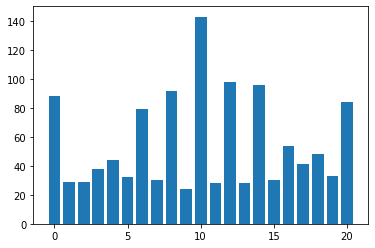

In [18]:
categories_counts = {i: 0 for i in range(21)}
for e in np.argmax(Y_train_1_ohe.toarray(), axis=1):
    categories_counts[e] += 1
categories_counts 
plt.bar(categories_counts.keys(), categories_counts.values())

<BarContainer object of 21 artists>

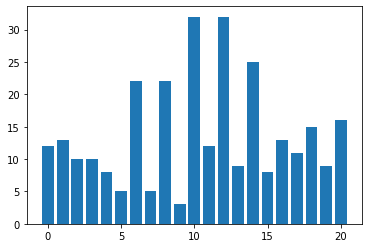

In [19]:
categories_counts = {i: 0 for i in range(21)}
for e in np.argmax(Y_valid_1_ohe.toarray(), axis=1):
    categories_counts[e] += 1
categories_counts 
plt.bar(categories_counts.keys(), categories_counts.values())

In [10]:
def img_preprocess(x):
    x = npimg.imread(x)
    x = x[50:145, :, :]
    x = cv2.cvtColor(x, cv2.COLOR_RGB2YUV)
    x = cv2.GaussianBlur(x, (3, 3), 0)
    x = cv2.resize(x, (100, 100))
    x = x / 255
    return x

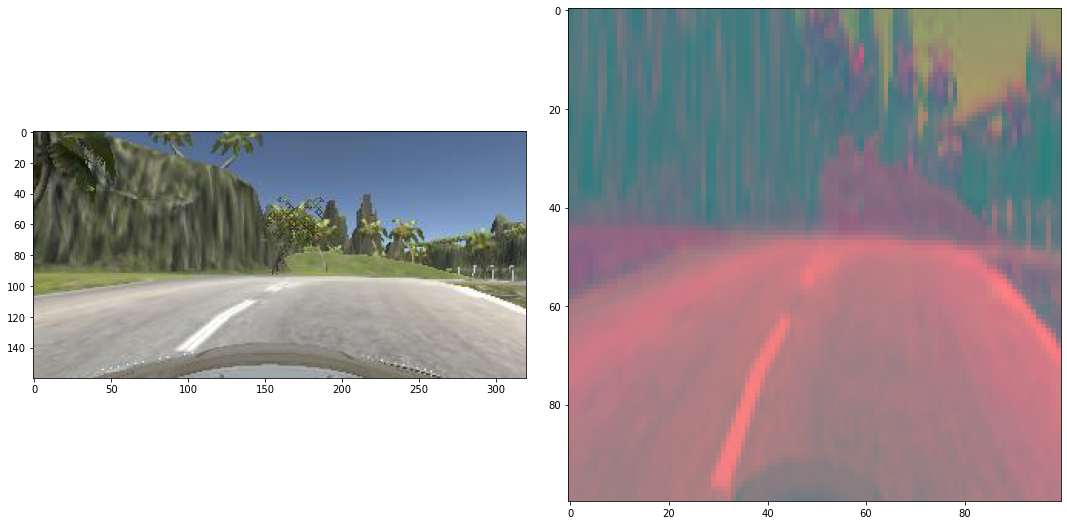

In [11]:
image = image_paths[228]
image_before = npimg.imread(image)
image_after = img_preprocess(image)

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axes[0].imshow(image_before)
axes[1].imshow(image_after)

In [12]:
X_train_preprocessed = np.array(list(map(img_preprocess, X_train)))
X_valid_preprocessed = np.array(list(map(img_preprocess, X_valid)))

In [23]:
from keras.applications.resnet50 import ResNet50
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

In [24]:
resnet.predict(X_valid_preprocessed[:1]).shape

(1, 4, 4, 2048)

In [25]:
for layer in resnet.layers[:-4]: 
    layer.trainable = False

In [82]:
def get_model():
    model = Sequential()
    resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(100, 100, 3))
    model.add(resnet)

    model.add(Dropout(0.5))
  
    model.add(Flatten())
  
    model.add(Dense(500, activation='elu'))
    model.add(Dropout(0.5)) 
    
    model.add(Dense(250, activation='elu'))
    model.add(Dropout(0.5))
  
    model.add(Dense(100, activation='elu'))
    model.add(Dropout(0.5))
  
    model.add(Dense(1))
  
    optimizer = Adam(lr=1e-3)
    model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
    return model

In [26]:
def get_model_categorical():
    model = Sequential()
    resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(100, 100, 3))
    for layer in resnet.layers[:-4]: 
        layer.trainable = False
    model.add(resnet)

    model.add(Dropout(0.5))
  
    model.add(Flatten())
  
    model.add(Dense(500, activation='relu', kernel_initializer=initializers.RandomNormal(stddev=1)))
    model.add(Dropout(0.5)) 
    
    model.add(Dense(250, activation='relu', kernel_initializer=initializers.RandomNormal(stddev=1)))
    model.add(Dropout(0.5))
  
    model.add(Dense(21, activation='softmax', kernel_initializer=initializers.RandomNormal(stddev=1)))
    model.add(Dropout(0.5))

  
    optimizer = Adam(lr=1e-3)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [136]:
def get_model_categorical_functional():
    inputs = keras.Input(shape=(100, 100, 3))
    x = ResNet50(weights='imagenet', include_top=False, input_shape=(100, 100, 3))(inputs)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(500, activation='relu', kernel_initializer=initializers.RandomNormal(stddev=1))(x)
    outputs = keras.layers.Dense(21,
                             kernel_initializer=initializers.RandomNormal(stddev=1),
                             activation='softmax')(x) 
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), # default from_logits=False
        metrics=[keras.metrics.SparseCategoricalAccuracy()]
    )
    return model

In [36]:
X_train_preprocessed[0].shape

(100, 100, 3)

In [13]:
def get_model_lenet_like():
    model = keras.Sequential(
        [
            keras.Input(shape=X_train_preprocessed[0].shape),
            Conv2D(32, kernel_size=(3, 3), activation="relu"),
            MaxPooling2D(pool_size=(2, 2)),
            Conv2D(64, kernel_size=(3, 3), activation="relu"),
            MaxPooling2D(pool_size=(2, 2)),
            Flatten(),
            Dropout(0.5),
            Dense(21, activation="softmax"),
        ]
    )
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3), metrics=['accuracy'])
    return model

In [14]:
def get_model_lenet_like_regression():
    model = keras.Sequential(
        [
            keras.Input(shape=X_train_preprocessed[0].shape),
            Conv2D(32, kernel_size=(3, 3), activation="relu"),
            MaxPooling2D(pool_size=(2, 2)),
            Conv2D(64, kernel_size=(3, 3), activation="relu"),
            MaxPooling2D(pool_size=(2, 2)),
            Flatten(),
            Dropout(0.5),
            Dense(1),
        ]
    )
    model.compile(loss='mse', optimizer=Adam(lr=1e-3), metrics=['accuracy'])
    return model

In [15]:
def get_model_lenet_like_regression_wide():
    model = keras.Sequential(
        [
            keras.Input(shape=X_train_preprocessed[0].shape),
            Conv2D(64, kernel_size=(3, 3), activation="relu"),
            MaxPooling2D(pool_size=(2, 2)),
            Conv2D(128, kernel_size=(3, 3), activation="relu"),
            MaxPooling2D(pool_size=(2, 2)),
            Flatten(),
            Dropout(0.5),
            Dense(1),
        ]
    )
    model.compile(loss='mse', optimizer=Adam(lr=1e-3), metrics=['accuracy'])
    return model

In [16]:
def get_model_lenet_like_regression_long():
    model = keras.Sequential(
        [
            keras.Input(shape=X_train_preprocessed[0].shape),
            Conv2D(32, kernel_size=(3, 3), activation="relu"),
            MaxPooling2D(pool_size=(2, 2)),
            Conv2D(64, kernel_size=(3, 3), activation="relu"),
            MaxPooling2D(pool_size=(2, 2)),
            Flatten(),
            Dropout(0.5),
            Dense(32),
            Dropout(0.5),
            Dense(1)
        ]
    )
    model.compile(loss='mse', optimizer=Adam(lr=1e-3), metrics=['accuracy'])
    return model

In [17]:
def get_model_lenet_like_regression_wide_long():
    model = keras.Sequential(
        [
            keras.Input(shape=X_train_preprocessed[0].shape),
            Conv2D(64, kernel_size=(3, 3), activation="relu"),
            MaxPooling2D(pool_size=(2, 2)),
            Conv2D(128, kernel_size=(3, 3), activation="relu"),
            MaxPooling2D(pool_size=(2, 2)),
            Flatten(),
            Dropout(0.5),
            Dense(64),
            Dropout(0.5),
            Dense(1)
        ]
    )
    model.compile(loss='mse', optimizer=Adam(lr=1e-3), metrics=['accuracy'])
    return model

In [29]:
def get_model_lenet_like_regression_wider_long():
    model = keras.Sequential(
        [
            keras.Input(shape=X_train_preprocessed[0].shape),
            Conv2D(128, kernel_size=(3, 3), activation="relu"),
            MaxPooling2D(pool_size=(2, 2)),
            Conv2D(256, kernel_size=(3, 3), activation="relu"),
            MaxPooling2D(pool_size=(2, 2)),
            Flatten(),
            Dropout(0.5),
            Dense(128),
            Dropout(0.5),
            Dense(1)
        ]
    )
    model.compile(loss='mse', optimizer=Adam(lr=1e-3), metrics=['accuracy'])
    return model

In [27]:
def get_model_lenet_like_regression_wider_longer():
    model = keras.Sequential(
        [
            keras.Input(shape=X_train_preprocessed[0].shape),
            Conv2D(128, kernel_size=(3, 3), activation="relu"),
            MaxPooling2D(pool_size=(2, 2)),
            Conv2D(256, kernel_size=(3, 3), activation="relu"),
            MaxPooling2D(pool_size=(2, 2)),
            Flatten(),
            Dropout(0.5),
            Dense(128),
            Dropout(0.5),
            Dense(64),
            Dropout(0.5),
            Dense(1)
        ]
    )
    model.compile(loss='mse', optimizer=Adam(lr=1e-3), metrics=['accuracy'])
    return model

In [31]:
def get_model_lenet_like_regression_wide_longer():
    model = keras.Sequential(
        [
            keras.Input(shape=X_train_preprocessed[0].shape),
            Conv2D(64, kernel_size=(3, 3), activation="relu"),
            MaxPooling2D(pool_size=(2, 2)),
            Conv2D(128, kernel_size=(3, 3), activation="relu"),
            MaxPooling2D(pool_size=(2, 2)),
            Flatten(),
            Dropout(0.5),
            Dense(64),
            Dropout(0.5),
            Dense(32),
            Dropout(0.5),
            Dense(1)
        ]
    )
    model.compile(loss='mse', optimizer=Adam(lr=1e-3), metrics=['accuracy'])
    return model

Epoch 1/25
5/5 [==============================] - 4s 756ms/step - loss: 1.3137 - accuracy: 0.0728 - val_loss: 1.1668 - val_accuracy: 0.0685
Epoch 2/25
5/5 [==============================] - 3s 681ms/step - loss: 0.6664 - accuracy: 0.0685 - val_loss: 0.3114 - val_accuracy: 0.0685
Epoch 3/25
5/5 [==============================] - 4s 763ms/step - loss: 0.3311 - accuracy: 0.0685 - val_loss: 0.3022 - val_accuracy: 0.0685
Epoch 4/25
5/5 [==============================] - 5s 902ms/step - loss: 0.3208 - accuracy: 0.0685 - val_loss: 0.2871 - val_accuracy: 0.0685
Epoch 5/25
5/5 [==============================] - 4s 865ms/step - loss: 0.2996 - accuracy: 0.0685 - val_loss: 0.2537 - val_accuracy: 0.0685
Epoch 6/25
5/5 [==============================] - 4s 847ms/step - loss: 0.2695 - accuracy: 0.0685 - val_loss: 0.2224 - val_accuracy: 0.0685
Epoch 7/25
5/5 [==============================] - 5s 916ms/step - loss: 0.2449 - accuracy: 0.0728 - val_loss: 0.2034 - val_accuracy: 0.0719
Epoch 8/25
5/5 [====

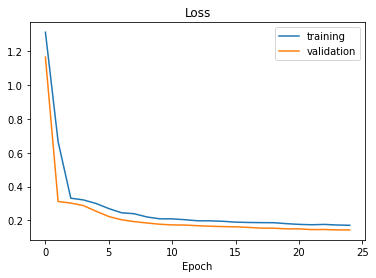

In [58]:
model_categorical = get_model_lenet_like_regression()

history = model_categorical.fit(
    X_train_preprocessed, 
    Y_train, 
    epochs=25, 
    validation_data=(X_valid_preprocessed, Y_valid),
    batch_size=256, 
    verbose=1, 
    shuffle=1
)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.show()



Epoch 1/25
5/5 [==============================] - 10s 2s/step - loss: 1.0681 - accuracy: 0.0634 - val_loss: 0.3586 - val_accuracy: 0.0685
Epoch 2/25
5/5 [==============================] - 11s 2s/step - loss: 0.3489 - accuracy: 0.0685 - val_loss: 0.3153 - val_accuracy: 0.0685
Epoch 3/25
5/5 [==============================] - 17s 3s/step - loss: 0.3362 - accuracy: 0.0685 - val_loss: 0.3025 - val_accuracy: 0.0685
Epoch 4/25
5/5 [==============================] - 10s 2s/step - loss: 0.3109 - accuracy: 0.0685 - val_loss: 0.2587 - val_accuracy: 0.0685
Epoch 5/25
5/5 [==============================] - 12s 2s/step - loss: 0.2649 - accuracy: 0.0693 - val_loss: 0.2009 - val_accuracy: 0.0719
Epoch 6/25
5/5 [==============================] - 12s 2s/step - loss: 0.2242 - accuracy: 0.0762 - val_loss: 0.1942 - val_accuracy: 0.0719
Epoch 7/25
5/5 [==============================] - 12s 2s/step - loss: 0.2164 - accuracy: 0.0822 - val_loss: 0.1774 - val_accuracy: 0.0719
Epoch 8/25
5/5 [==================

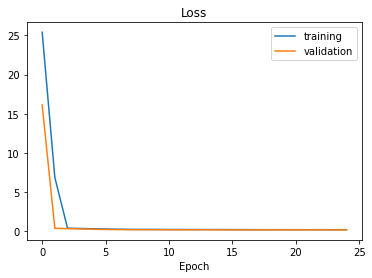

In [65]:
model = get_model_lenet_like_regression_wide()

history_1 = model.fit(
    X_train_preprocessed, 
    Y_train, 
    epochs=25, 
    validation_data=(X_valid_preprocessed, Y_valid),
    batch_size=256, 
    verbose=1, 
    shuffle=1
)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.show()



Epoch 1/25
5/5 [==============================] - 5s 1s/step - loss: 4.7092 - accuracy: 0.0599 - val_loss: 0.3008 - val_accuracy: 0.0685
Epoch 2/25
5/5 [==============================] - 5s 981ms/step - loss: 0.3437 - accuracy: 0.0685 - val_loss: 0.3233 - val_accuracy: 0.0685
Epoch 3/25
5/5 [==============================] - 5s 1s/step - loss: 0.3427 - accuracy: 0.0685 - val_loss: 0.3164 - val_accuracy: 0.0685
Epoch 4/25
5/5 [==============================] - 6s 1s/step - loss: 0.3328 - accuracy: 0.0685 - val_loss: 0.3113 - val_accuracy: 0.0685
Epoch 5/25
5/5 [==============================] - 6s 1s/step - loss: 0.3388 - accuracy: 0.0685 - val_loss: 0.3107 - val_accuracy: 0.0685
Epoch 6/25
5/5 [==============================] - 5s 1s/step - loss: 0.3326 - accuracy: 0.0685 - val_loss: 0.3061 - val_accuracy: 0.0685
Epoch 7/25
5/5 [==============================] - 5s 983ms/step - loss: 0.3187 - accuracy: 0.0685 - val_loss: 0.2664 - val_accuracy: 0.0685
Epoch 8/25
5/5 [===================

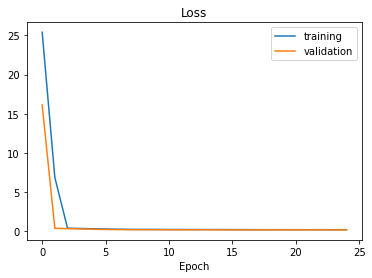

In [66]:
model = get_model_lenet_like_regression_long()

history_2 = model.fit(
    X_train_preprocessed, 
    Y_train, 
    epochs=25, 
    validation_data=(X_valid_preprocessed, Y_valid),
    batch_size=256, 
    verbose=1, 
    shuffle=1
)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.show()



Epoch 1/25
5/5 [==============================] - 14s 3s/step - loss: 133.8154 - accuracy: 0.0668 - val_loss: 16.5849 - val_accuracy: 0.0685
Epoch 2/25
5/5 [==============================] - 14s 3s/step - loss: 6.1922 - accuracy: 0.0659 - val_loss: 1.4348 - val_accuracy: 0.0514
Epoch 3/25
5/5 [==============================] - 13s 3s/step - loss: 0.7524 - accuracy: 0.0668 - val_loss: 0.3941 - val_accuracy: 0.0685
Epoch 4/25
5/5 [==============================] - 13s 3s/step - loss: 0.3540 - accuracy: 0.0685 - val_loss: 0.3133 - val_accuracy: 0.0685
Epoch 5/25
5/5 [==============================] - 14s 3s/step - loss: 0.3348 - accuracy: 0.0685 - val_loss: 0.3139 - val_accuracy: 0.0685
Epoch 6/25
5/5 [==============================] - 13s 3s/step - loss: 0.3352 - accuracy: 0.0685 - val_loss: 0.3139 - val_accuracy: 0.0685
Epoch 7/25
5/5 [==============================] - 13s 3s/step - loss: 0.3309 - accuracy: 0.0685 - val_loss: 0.2765 - val_accuracy: 0.0685
Epoch 8/25
5/5 [===============

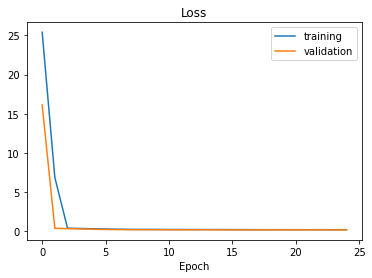

In [67]:
model = get_model_lenet_like_regression_wide_long()

history_3 = model.fit(
    X_train_preprocessed, 
    Y_train, 
    epochs=25, 
    validation_data=(X_valid_preprocessed, Y_valid),
    batch_size=256, 
    verbose=1, 
    shuffle=1
)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.show()



In [72]:
log_dir = "logs/" + 'model_regular' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=2,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

model = get_model_lenet_like_regression_wide_long()

model.fit(
    X_train_preprocessed, 
    Y_train, 
    epochs=100, 
    validation_data=(X_valid_preprocessed, Y_valid),
    batch_size=256, 
    verbose=0, 
    shuffle=1,
    callbacks=[tensorboard_callback, es_callback]
)

In [26]:
log_dir = "logs/" + 'model_basic' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback_2 = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch = 100000000)
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

model = get_model_lenet_like_regression()

model.fit(
    X_train_preprocessed, 
    Y_train, 
    epochs=100, 
    validation_data=(X_valid_preprocessed, Y_valid),
    batch_size=256, 
    verbose=0, 
    shuffle=1,
    callbacks=[tensorboard_callback_2, es_callback]
)

In [25]:
log_dir = "logs/" + 'model_wide' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback_2 = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch = 100000000)
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

model = get_model_lenet_like_regression_wide()

model.fit(
    X_train_preprocessed, 
    Y_train, 
    epochs=100, 
    validation_data=(X_valid_preprocessed, Y_valid),
    batch_size=256, 
    verbose=0, 
    shuffle=1,
    callbacks=[tensorboard_callback_2, es_callback]
)

In [24]:
log_dir = "logs/" + 'model_long' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback_2 = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch = 100000000)
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

model = get_model_lenet_like_regression_long()

model.fit(
    X_train_preprocessed, 
    Y_train, 
    epochs=100, 
    validation_data=(X_valid_preprocessed, Y_valid),
    batch_size=256, 
    verbose=0, 
    shuffle=1,
    callbacks=[tensorboard_callback_2, es_callback]
)

In [23]:
log_dir = "logs/" + 'model_wide_long' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback_2 = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch = 100000000)
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

model = get_model_lenet_like_regression_wide_long()

model.fit(
    X_train_preprocessed, 
    Y_train, 
    epochs=100, 
    validation_data=(X_valid_preprocessed, Y_valid),
    batch_size=256, 
    verbose=0, 
    shuffle=1,
    callbacks=[tensorboard_callback_2, es_callback]
)

In [28]:
log_dir = "logs/" + 'model_wider_longer' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback_2 = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch = 100000000)
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

model = get_model_lenet_like_regression_wider_longer()

model.fit(
    X_train_preprocessed, 
    Y_train, 
    epochs=100, 
    validation_data=(X_valid_preprocessed, Y_valid),
    batch_size=256, 
    verbose=0, 
    shuffle=1,
    callbacks=[tensorboard_callback_2, es_callback]
)

In [30]:
log_dir = "logs/" + 'model_wider_long' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback_2 = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch = 100000000)
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

model = get_model_lenet_like_regression_wider_long()

model.fit(
    X_train_preprocessed, 
    Y_train, 
    epochs=100, 
    validation_data=(X_valid_preprocessed, Y_valid),
    batch_size=256, 
    verbose=0, 
    shuffle=1,
    callbacks=[tensorboard_callback_2, es_callback]
)

In [32]:
log_dir = "logs/" + 'model_wide_longer' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback_2 = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch = 100000000)
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

model = get_model_lenet_like_regression_wide_longer()

model.fit(
    X_train_preprocessed, 
    Y_train, 
    epochs=100, 
    validation_data=(X_valid_preprocessed, Y_valid),
    batch_size=256, 
    verbose=0, 
    shuffle=1,
    callbacks=[tensorboard_callback_2, es_callback]
)